In [1]:
from syngem_utils import *
from load_models import *

In [2]:
import torch
import pandas as pd
import numpy as np
import pickle as pkl
import argparse
import yaml
import scipy
from munkres import Munkres
import networkx as nx
import warnings
warnings.filterwarnings('ignore')

In [3]:
batch_of_images = get_images_cifar10(batch_size = 100)

Files already downloaded and verified
Files already downloaded and verified


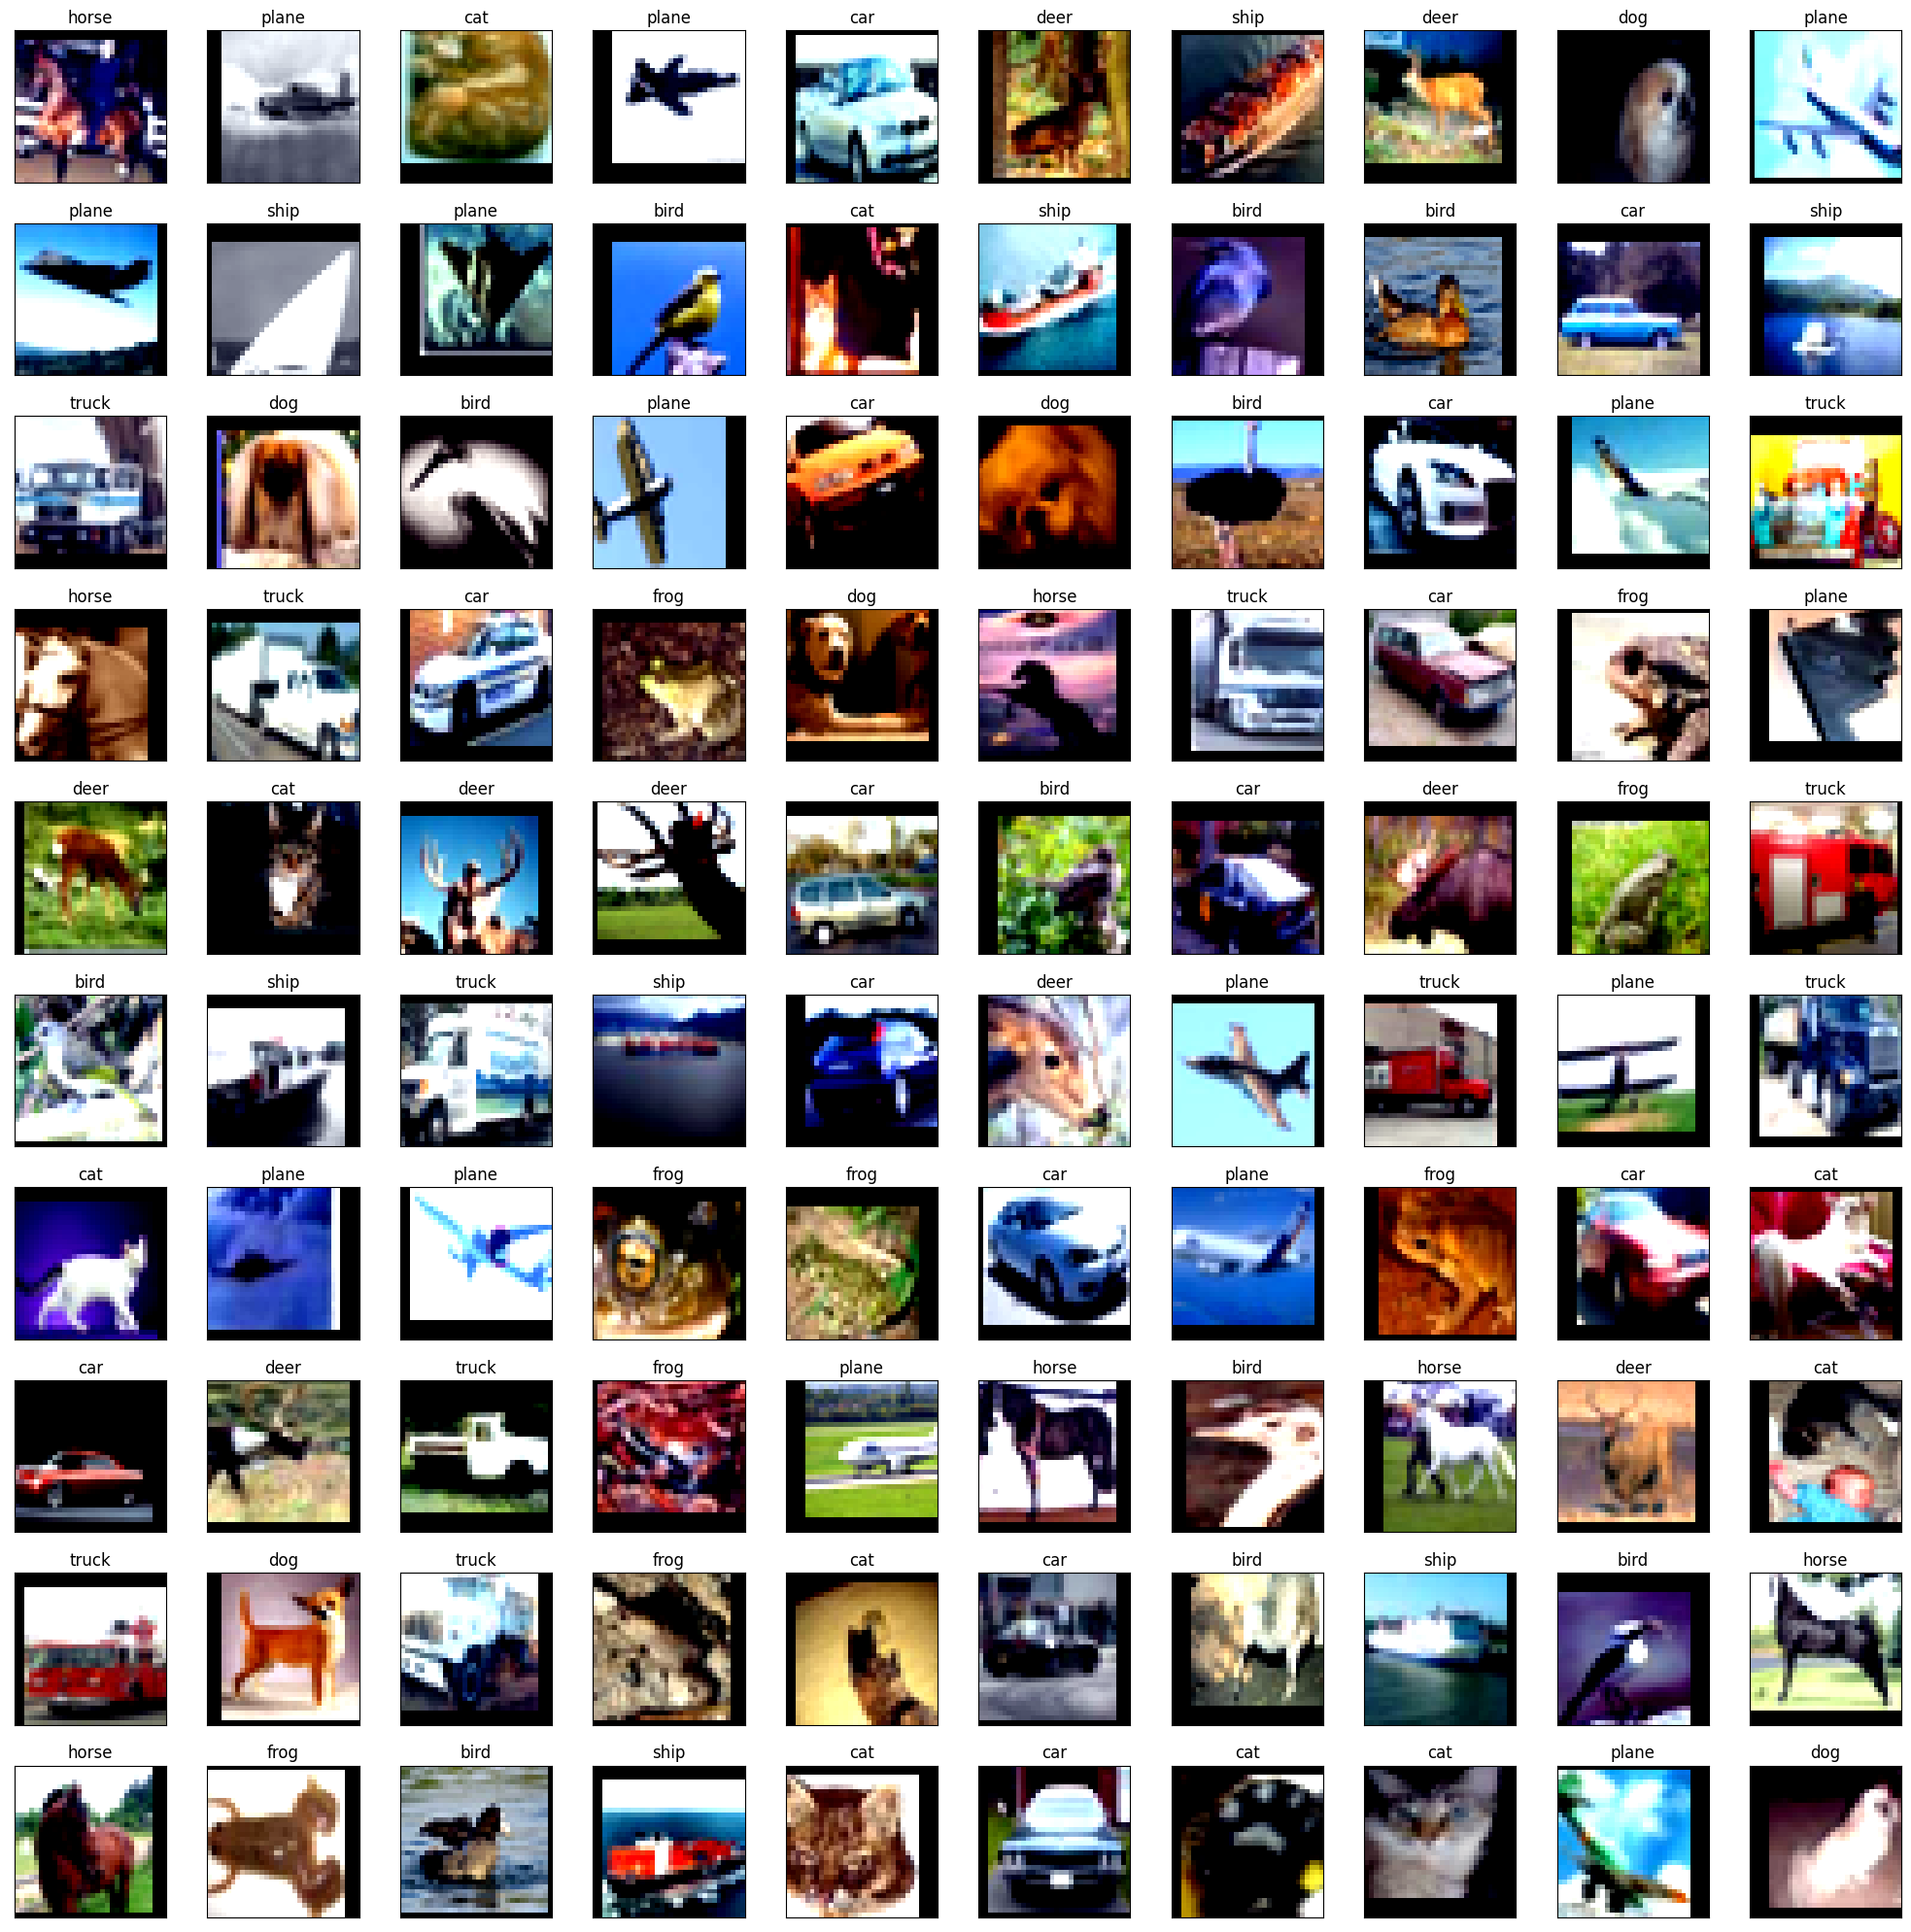

In [4]:
images, _ = batch_of_images.get_new_images(output = True)
batch_of_images.display((20,20))

In [5]:
# load model
gem_model = load_gemini_resnet20_1_44_sparsity()
syn_model_big = load_synflow_resnet20_32_sparsity()
syn_model = load_synflow_resnet20_18_sparsity()

=> Reading YAML config from Configs/hypercube/resnet20/resnet20_quantized_iter_hc_target_sparsity_1_4_highreg.yml
=> Reading YAML config from Configs/synflow_fc.yml
==> Conv Type: SubnetConv
==> BN Type: AffineBatchNorm
==> Building first layer


In [6]:
# check sparsity
gem_sparsity = check_sparsity(gem_model)
syn_big_sparsity = check_sparsity(syn_model_big)
syn_sparsity = check_sparsity(syn_model)

In [7]:
print("syn_model:", syn_sparsity)
print("syn_model_big:", syn_big_sparsity)
print("gem_model:", gem_sparsity)

syn_model: {'overall_sparsity': 17.948}
syn_model_big: {'overall_sparsity': 31.874}
gem_model: {'overall_sparsity': 1.438}


In [8]:
# get units
gem_filters = get_filters(gem_model)
syn_filters = get_filters(syn_model)
syn_filters_big = get_filters(syn_model_big)

In [9]:
init_syn_model = load_synflow_resnet20_1_66_sparsity()
init_syn_filters = get_filters(init_syn_model)

# to do
### --> make most of these cells into functions
### --> add final layer to get_feature_map function (if it doesnt break the existing code) (DONE)

In [11]:
syn_activations = get_activation_series(images, syn_filters, "last")
syn_activations_big = get_activation_series(images, syn_filters_big, "last")
gem_activations = get_activation_series(images, gem_filters, "last")

In [14]:
gem_cor = get_correlation(gem_activations)
syn_cor = get_correlation(syn_activations)
syn_cor_big = get_correlation(syn_activations_big)

gem_syn_cor = get_correlation(gem_activations, syn_activations)
syn_syn_cor = get_correlation(syn_activations_big, syn_activations)

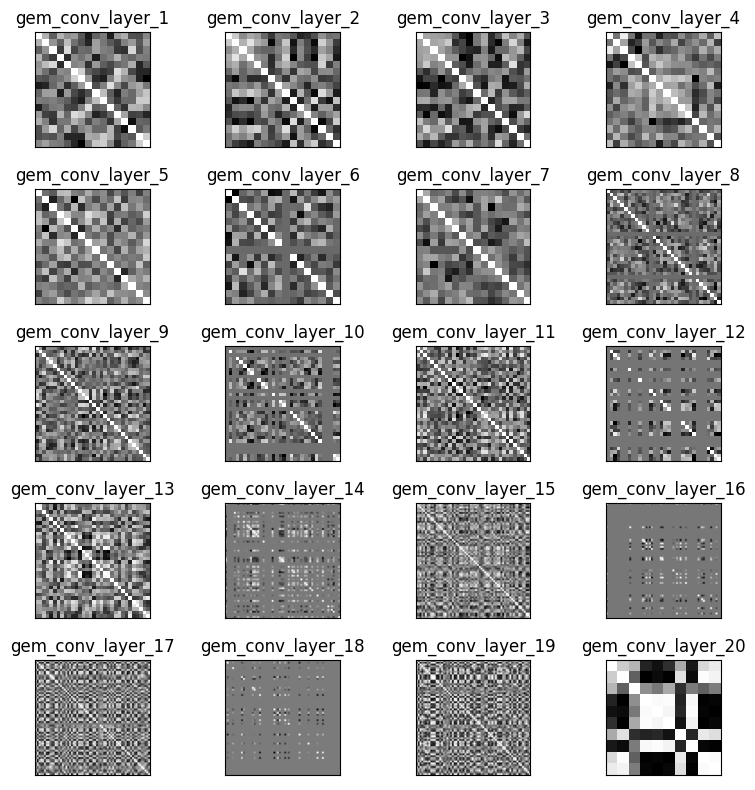

In [16]:
fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(8,8))

for idx, ax in enumerate(axs.flat):
    img = gem_cor[idx]
    ax.imshow(img, cmap = "gray")
    ax.set_title(f"gem_conv_layer_{idx + 1}")
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    

plt.tight_layout()
plt.show()

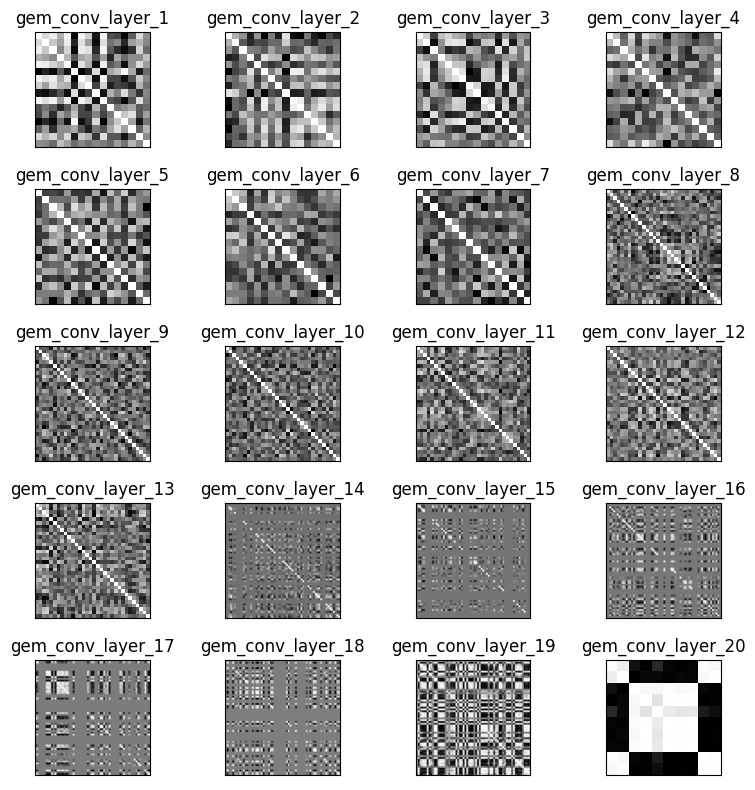

In [17]:
fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(8,8))

for idx, ax in enumerate(axs.flat):
    img = syn_cor[idx]
    ax.imshow(img, cmap = "gray")
    ax.set_title(f"gem_conv_layer_{idx + 1}")
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    

plt.tight_layout()
plt.show()

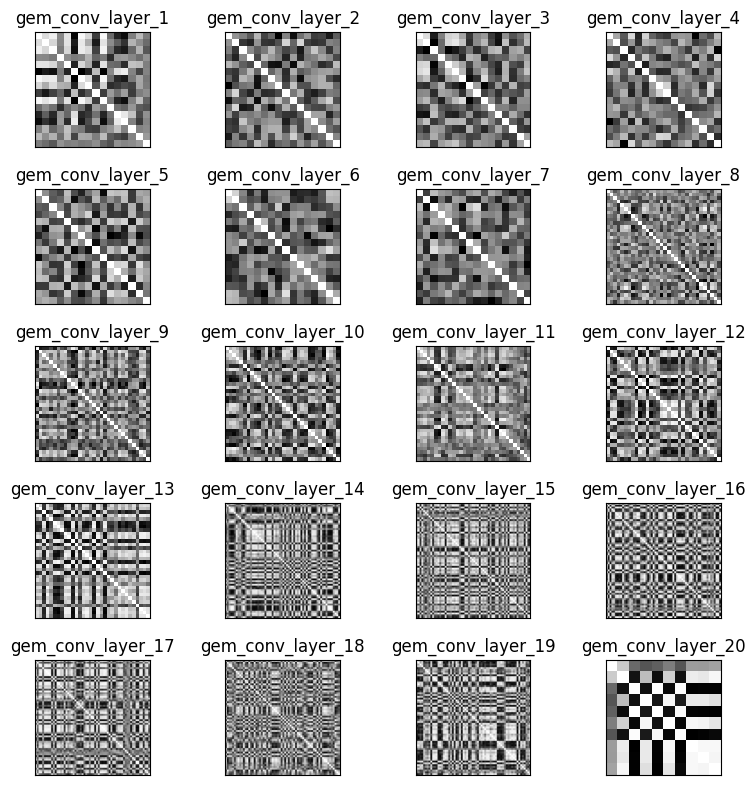

In [18]:
fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(8,8))

for idx, ax in enumerate(axs.flat):
    img = syn_cor_big[idx]
    ax.imshow(img, cmap = "gray")
    ax.set_title(f"gem_conv_layer_{idx + 1}")
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    

plt.tight_layout()
plt.show()

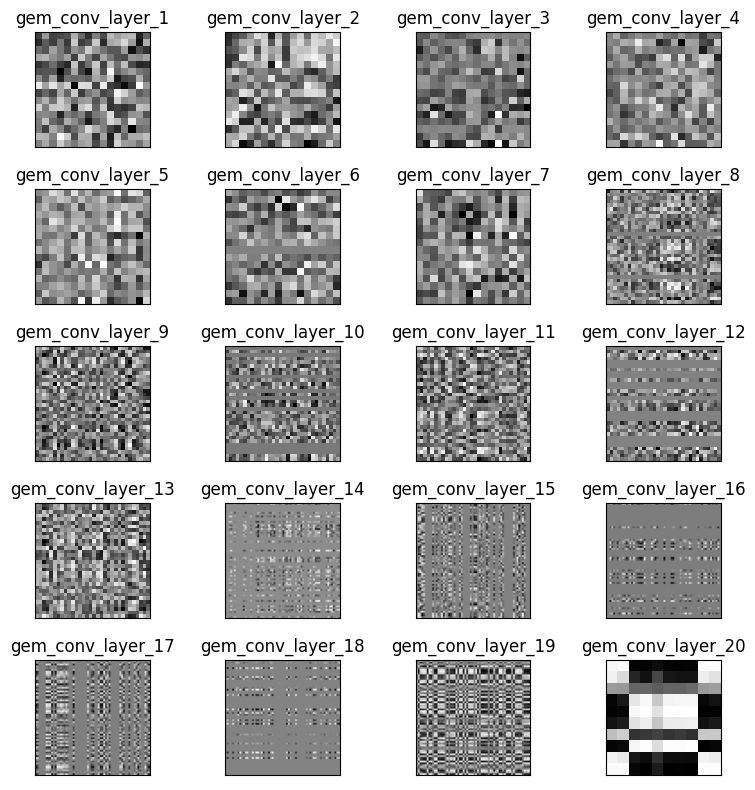

In [19]:
fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(8,8))

for idx, ax in enumerate(axs.flat):
    img = gem_syn_cor[idx]
    ax.imshow(img, cmap = "gray")
    ax.set_title(f"gem_conv_layer_{idx + 1}")
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    

plt.tight_layout()
plt.show()

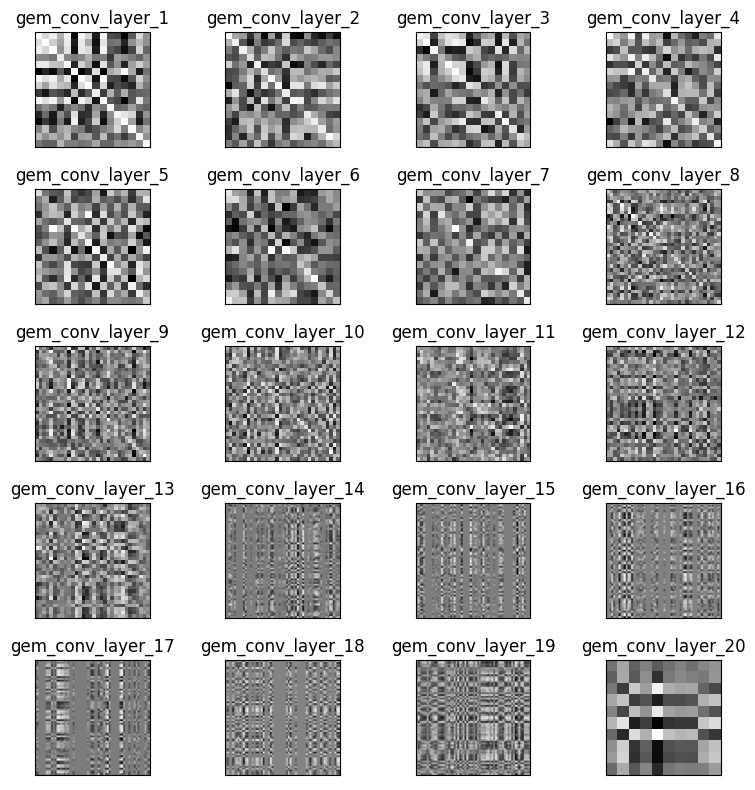

In [20]:
fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(8,8))

for idx, ax in enumerate(axs.flat):
    img = syn_syn_cor[idx]
    ax.imshow(img, cmap = "gray")
    ax.set_title(f"gem_conv_layer_{idx + 1}")
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    

plt.tight_layout()
plt.show()

In [22]:
# Find max bipartite matching of between-net correlation matrix
gem_syn_match_max_no_diag = find_max_matching(gem_syn_cor[12])
gem_syn_mat_max = change_mat_max(gem_syn_cor[12],gem_syn_match_max_no_diag)

In [23]:
# Find max bipartite matching of between-net correlation matrix
gem_syn_match_semi_no_diag = find_semi_matching(gem_syn_cor[12])
gem_syn_mat_semi = change_mat_semi(gem_syn_cor[12],gem_syn_match_semi_no_diag)

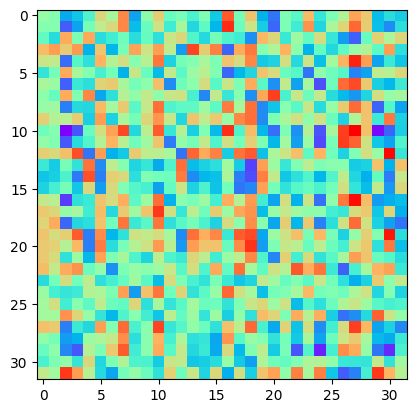

In [24]:
plt.imshow(gem_syn_cor[12], cmap = "rainbow")
plt.show()

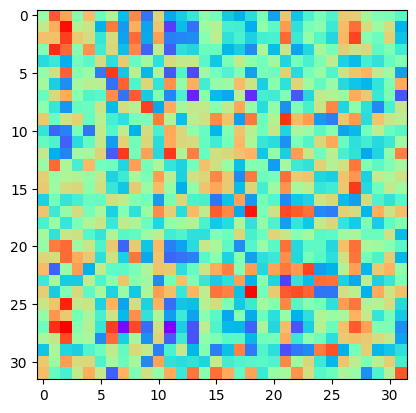

In [25]:
plt.imshow(gem_syn_mat_max, cmap = "rainbow")
plt.show()

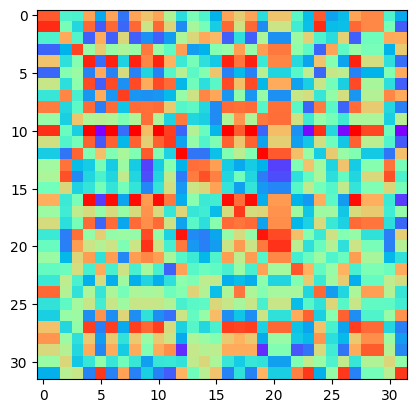

In [26]:
plt.imshow(gem_syn_mat_semi, cmap = "rainbow")
plt.show()

# to do
## 1. use greedy matching to compare max matching (maybe graph like paper)
## 1.1 if same, max ist also best 
## 1.2 also look at array to see which unit is "connected" to which 
## 2. use weight max match combined with isabel or other distance measure, e.g use distance measure to create matrix with distances and then use same algorithms to structure them (waaaay better than isables random local search)

## 2.1 ofc use min_weight_matching and .min for match and greedy respectively

## 3. do analysis of which filter is connected to which feature in images